# Raster-vector interactions {#raster-vector}

## Prerequisites

In [1]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 6
pd.options.display.max_columns = 6
pd.options.display.max_colwidth = 35
plt.rcParams["figure.figsize"] = (5, 5)

Let's import the required packages:

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterstats
from rasterio.plot import show

and load the sample data:

In [3]:
src_srtm = rasterio.open("data/srtm.tif")
zion = gpd.read_file("data/zion.gpkg")
zion_points = gpd.read_file("data/zion_points.gpkg")

/home/michael/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/michael/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


## Introduction

## Raster cropping

Many geographic data projects involve integrating data from many different sources, such as remote sensing images (rasters) and administrative boundaries (vectors). Often the extent of input raster datasets is larger than the area of interest. In this case raster **cropping** and **masking** are useful for unifying the spatial extent of input data. Both operations reduce object memory use and associated computational resources for subsequent analysis steps, and may be a necessary preprocessing step before creating attractive maps involving raster data.

We will use two objects to illustrate raster cropping:

* The `srtm.tif` raster representing elevation (meters above sea level) in south-western Utah
* The `zion.gpkg` vector layer representing the Zion National Park

Both target and cropping objects must have the same projection. The following reprojects the vector layer `zion` into the CRS of the raster `src_srtm`:

In [4]:
zion = zion.to_crs(src_srtm.crs)

To mask the image, i.e., convert all pixels which do not intersect with the `zion` polygon to "No Data", we use the `rasterio.mask.mask` function as follows:

In [5]:
out_image_mask, out_transform_mask = rasterio.mask.mask(
    src_srtm, 
    zion["geometry"], 
    crop=False, 
    nodata=9999
)

Note that we need to specify a "No Data" value in agreement with the raster data type. Since `srtm.tif` is of type `uint16`, we choose `9999` (a positive integer that is guaranteed not to occur in the raster). 

The result is the `out_image` array with the masked values: 

In [6]:
out_image_mask

array([[[9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        ...,
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999],
        [9999, 9999, 9999, ..., 9999, 9999, 9999]]], dtype=uint16)

and the new `out_transform`:

In [7]:
out_transform_mask

Affine(0.0008333333332777796, 0.0, -113.23958321278403,
       0.0, -0.0008333333332777843, 37.512916763165805)

Note that masking (without cropping!) does not modify the raster spatial configuration. Therefore, the new transform is identical to the original:

In [8]:
src_srtm.transform

Affine(0.0008333333332777796, 0.0, -113.23958321278403,
       0.0, -0.0008333333332777843, 37.512916763165805)

Unfortunately, the `out_image` and `out_transform` object do not contain any information indicating that `9999` represents "No Data". To associate the information with the raster, we must write it to file along with the corresponding metadata. For example, to write the cropped raster to file, we need to modify the "No Data" setting in the metadata:

In [9]:
out_meta = src_srtm.meta
out_meta.update(nodata=9999)
out_meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 9999,
 'width': 465,
 'height': 457,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008333333332777796, 0.0, -113.23958321278403,
        0.0, -0.0008333333332777843, 37.512916763165805)}

Then we can write the cropped raster to file:

In [10]:
new_dataset = rasterio.open("output/srtm_masked.tif", "w", **out_meta)
new_dataset.write(out_image_mask)
new_dataset.close()

Now we can re-import the raster:

In [11]:
src_srtm_mask = rasterio.open("output/srtm_masked.tif")

The `.meta` property contains the `nodata` entry. Now, any relevant operation (such as plotting) will take "No Data" into account:

In [12]:
src_srtm_mask.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 9999.0,
 'width': 465,
 'height': 457,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008333333332777796, 0.0, -113.23958321278403,
        0.0, -0.0008333333332777843, 37.512916763165805)}

Cropping means reducing the raster extent to the extent of the vector layer:

* To crop *and* mask, we can use the same in `rasterio.mask.mask` expression shown above for masking, just setting `crop=True` instead of `crop=False`. 
* To just crop, *without* masking, we can derive the extent polygon and then crop using it.

For example, here is how we can obtain the extent polygon of `zion`, as a `shapely` geometry object:

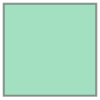

In [13]:
bb = zion.unary_union.envelope
bb

The extent can now be used for masking. Here, we are also using the `all_touched=True` option so that pixels partially overlapping with the extent are included:

In [14]:
out_image_crop, out_transform_crop = rasterio.mask.mask(
    src_srtm, 
    [bb], 
    crop=True, 
    all_touched=True, 
    nodata=9999
)

@fig-raster-crop shows the original raster, and the cropped and masked results.

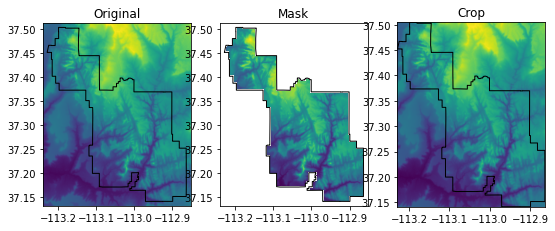

In [15]:
#| label: fig-raster-crop
#| fig-cap: "Raster masking and cropping"

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
show(src_srtm, ax=axes[0])
zion.plot(ax=axes[0], color="none", edgecolor="black")
show(src_srtm_mask, ax=axes[1])
zion.plot(ax=axes[1], color="none", edgecolor="black")
show(out_image_crop, transform=out_transform_crop, ax=axes[2])
zion.plot(ax=axes[2], color="none", edgecolor="black")
axes[0].set_title("Original")
axes[1].set_title("Mask")
axes[2].set_title("Crop");

## Raster extraction

Raster extraction is the process of identifying and returning the values associated with a 'target' raster at specific locations, based on a (typically vector) geographic 'selector' object. The reverse of raster extraction — assigning raster cell values based on vector objects — is rasterization, described in Section ...

In the following examples, we use a third-party package called `rasterstats`, which is specifically aimed at extracting raster values: 

* to *points*, via the `rasterstats.point_query` function, or 
* to *polygons*, via the `rasterstats.zonal_stats` function.

### Extraction to points

The basic example is of extracting the value of a raster cell at specific points. For this purpose, we will use `zion_points`, which contain a sample of 30 locations within the Zion National Park (Figure ...). The following expression extracts elevation values from `srtm`:

In [27]:
result = rasterstats.point_query(
    zion_points, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform,
    interpolate='nearest'
)

The resulting object is a `list` of raster values, corresponding to `zion_points`:

In [ ]:
result[:5]

To create a `DataFrame` with points' IDs (one value per vector's row) and related `srtm` values for each point, we need to assign it:

In [30]:
zion_points['elev'] = result
zion_points

,geometry,elev
0,POINT (-112.91587 37.20013),1802.0
1,POINT (-113.09369 37.39263),2433.0
2,POINT (-113.02462 37.33466),1886.0
...,...,...
27,POINT (-113.03655 37.23446),1372.0
28,POINT (-113.13933 37.39004),1905.0
29,POINT (-113.09677 37.24237),1574.0


### Extraction to lines

Raster extraction also works with line selectors. Then, it extracts one value for each raster cell touched by a line. However, the line extraction approach is not recommended to obtain values along the transects as it is hard to get the correct distance between each pair of extracted raster values.

In this case, a better approach is to split the line into many points and then extract the values for these points. To demonstrate this, the code below creates zion_transect, a straight line going from northwest to southeast of the Zion National Park, illustrated in Figure 6.3(A) (see Section 2.2 for a recap on the vector data model):

zion_transect = cbind(c(-113.2, -112.9), c(37.45, 37.2)) |>
  st_linestring() |> 
  st_sfc(crs = crs(srtm)) |>
  st_sf(geometry = _)

The utility of extracting heights from a linear selector is illustrated by imagining that you are planning a hike. The method demonstrated below provides an ‘elevation profile’ of the route (the line does not need to be straight), useful for estimating how long it will take due to long climbs.

The first step is to add a unique id for each transect. Next, with the st_segmentize() function we can add points along our line(s) with a provided density (dfMaxLength) and convert them into points with st_cast().

zion_transect$id = 1:nrow(zion_transect)
zion_transect = st_segmentize(zion_transect, dfMaxLength = 250)
zion_transect = st_cast(zion_transect, "POINT")

Now, we have a large set of points, and we want to derive a distance between the first point in our transects and each of the subsequent points. In this case, we only have one transect, but the code, in principle, should work on any number of transects:

zion_transect = zion_transect |> 
  group_by(id) |> 
  mutate(dist = st_distance(geometry)[, 1]) 

Finally, we can extract elevation values for each point in our transects and combine this information with our main object.

zion_elev = terra::extract(srtm, vect(zion_transect))
zion_transect = cbind(zion_transect, zion_elev)

The resulting zion_transect can be used to create elevation profiles, as illustrated in Figure 6.3(B).

### Extraction to polygons

The final type of geographic vector object for raster extraction is polygons. Like lines, polygons tend to return many raster values per polygon. Typically, we generate summary statistics for raster values per polygon, for example to characterize a single region or to compare many regions. The generation of raster summary statistics, by polygons, is demonstrated in the code below, which creates a list of summary statistics (in this case a list of length 1, since there is just one polygon), again using `rasterstats`:

In [31]:
rasterstats.zonal_stats(
    zion, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform, 
    stats = ['mean', 'min', 'max']
)

[{'min': 1122.0, 'max': 2661.0, 'mean': 1818.211830154405}]

The results provide useful summaries, for example that the maximum height in the park is around 2,661 meters above see level (other summary statistics, such as standard deviation, can also be calculated in this way). Because there is only one polygon in the example a data frame with a single row is returned; however, the method works when multiple selector polygons are used.

Note the `stats` argument, where we determine what type of statistics are calculated per polygon. Possible values other than `"mean"`, `"min"`, `"max"` are:

* `"count"`—The number of valid (i.e., excluding "No Data") pixels
* `"nodata"`—The number of pixels with "No Data"
* `"majority"`—The most frequently occurring value
* `"median"`—The median value

See the [documentation](https://pythonhosted.org/rasterstats/manual.html#statistics) for the complete list. Additionally, the `zonal_stats` function accepts user-defined functions for calculating any custom statistics.

From polygon (nlcd)...

The similar approach works for counting occurrences of categorical raster values within polygons. This is illustrated with a land cover dataset (nlcd) from the spDataLarge package in Figure 6.4(B), and demonstrated in the code below:

nlcd = rast(system.file("raster/nlcd.tif", package = "spDataLarge"))
zion2 = st_transform(zion, st_crs(nlcd))
zion_nlcd = terra::extract(nlcd, vect(zion2))
zion_nlcd |> 
  group_by(ID, levels) |>
  count()
#> # A tibble: 7 × 3
#> # Groups:   ID, levels [7]
#>      ID levels         n
#>   <dbl> <fct>      <int>
#> 1     1 Developed   4205
#> 2     1 Barren     98285
#> 3     1 Forest    298299
#> 4     1 Shrubland 203701
#> # … with 3 more rows

## Rasterization

...

## Spatial vectorization

Spatial vectorization is the counterpart of rasterization (Section ...), but in the opposite direction. It involves converting spatially continuous raster data into spatially discrete vector data such as points, lines or polygons.

There are three standard methods to convert a raster to a vector layer:

* Raster to polygons
* Raster to points
* Raster to contours

The most straightforward form of vectorization is the first one, converting raster cells to polygons, where each pixel is represented by a rectangular polygon. The second method, raster to points, has the additional step of calculating polygon centroids. The third method, raster to contours, is somewhat unrelated. Let us demonstrate the three in the given order.

In [16]:
src = rasterio.open("data/grain.tif")

To polygons... ...


FIGURE 6.9: Illustration of vectorization of raster (left) into polygons (dissolve = FALSE; center) and aggregated polygons (dissolve = TRUE; right). 

In [17]:
src = rasterio.open("data/elev.tif")

To points...

In [18]:
src = rasterio.open("data/elev.tif")

To contours...

...

Another common type of spatial vectorization is the creation of contour lines representing lines of continuous height or temperatures (isotherms) for example. We will use a real-world digital elevation model (DEM) because the artificial raster elev produces parallel lines (task for the reader: verify this and explain why this happens). Contour lines can be created with the terra function as.contour(), which is itself a wrapper around filled.contour(), as demonstrated below (not shown):

Contours can also be added to existing plots with functions such as contour(), rasterVis::contourplot() or tmap::tm_iso(). As illustrated in Figure 6.8, isolines can be labelled.

The final type of vectorization involves conversion of rasters to polygons. This can be done with terra::as.polygons(), which converts each raster cell into a polygon consisting of five coordinates, all of which are stored in memory (explaining why rasters are often fast compared with vectors!).

This is illustrated below by converting the grain object into polygons and subsequently dissolving borders between polygons with the same attribute values (also see the dissolve argument in as.polygons()).



## Exercises
